In [6]:
import os
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime as dt 


In [7]:
os.listdir()

['error_log_1.txt', 'eval_logs.ipynb', 'raw_2021-07-25.csv']

## Prepare and clean the data

In [8]:
fn = "raw_2021-07-25.csv"
df = pd.read_csv(fn)
df.tail()

,time,ver,charge_state,I_L1,I_L2,I_L3,Temp,V_L1,V_L2,V_L3,...,E_cyc_lb,E_hb,E_lb,I_max,I_min,watchdog,standby,remote_lock,max_I_cmd,FailSafe_I
7437,11:27:27,264,2,0,0,0,322,237,235,240,...,12088,2,61695,10,6,15000,4,1,100,10
7438,11:27:32,264,2,0,0,0,322,236,235,240,...,12088,2,61695,10,6,15000,4,1,100,10
7439,11:27:38,264,2,0,0,0,322,236,235,240,...,12088,2,61695,10,6,15000,4,1,100,10
7440,11:27:43,264,2,0,0,0,322,236,235,240,...,12088,2,61695,10,6,15000,4,1,100,10
7441,11:27:48,264,2,0,0,0,322,236,235,240,...,12088,2,61695,10,6,15000,4,1,100,10


Create ``datetime`` column

In [9]:
date_str = fn.split(".")[0][-10:]

In [10]:
df["datetime"] = [dt.datetime.strptime(date_str+time_str, "%Y-%m-%d%H:%M:%S") for time_str in df["time"]]
df.drop(columns="time", axis=1, inplace=True)
df.head()

,ver,charge_state,I_L1,I_L2,I_L3,Temp,V_L1,V_L2,V_L3,ext_lock,...,E_hb,E_lb,I_max,I_min,watchdog,standby,remote_lock,max_I_cmd,FailSafe_I,datetime
0,264,2,0,0,0,272,237,236,239,1,...,2,49607,10,6,15000,4,1,0,10,2021-07-25 00:53:32
1,264,2,0,0,0,272,237,235,239,1,...,2,49607,10,6,15000,4,1,0,10,2021-07-25 00:53:37
2,264,2,0,0,0,272,237,235,239,1,...,2,49607,10,6,15000,4,1,0,10,2021-07-25 00:53:43
3,264,2,0,0,0,272,236,235,238,1,...,2,49607,10,6,15000,4,1,0,10,2021-07-25 00:53:48
4,264,2,0,0,0,272,236,235,238,1,...,2,49607,10,6,15000,4,1,0,10,2021-07-25 00:53:53


Compute energy from ``high_byte`` and ``low_byte``

In [11]:
df["E [kWh]"] = (2**16 * df["E_hb"] + df["E_lb"]) / 1000
df["E_cyc [kWh]"] = (2**16 * df["E_cyc_hb"] + df["E_cyc_lb"]) / 1000
df.drop(columns=["E_hb", "E_lb", "E_cyc_hb", "E_cyc_lb"], axis=1, inplace=True)
df.head()

,ver,charge_state,I_L1,I_L2,I_L3,Temp,V_L1,V_L2,V_L3,ext_lock,...,I_max,I_min,watchdog,standby,remote_lock,max_I_cmd,FailSafe_I,datetime,E [kWh],E_cyc [kWh]
0,264,2,0,0,0,272,237,236,239,1,...,10,6,15000,4,1,0,10,2021-07-25 00:53:32,180.679,0.0
1,264,2,0,0,0,272,237,235,239,1,...,10,6,15000,4,1,0,10,2021-07-25 00:53:37,180.679,0.0
2,264,2,0,0,0,272,237,235,239,1,...,10,6,15000,4,1,0,10,2021-07-25 00:53:43,180.679,0.0
3,264,2,0,0,0,272,236,235,238,1,...,10,6,15000,4,1,0,10,2021-07-25 00:53:48,180.679,0.0
4,264,2,0,0,0,272,236,235,238,1,...,10,6,15000,4,1,0,10,2021-07-25 00:53:53,180.679,0.0


Scale to real units

In [12]:
df["T [°C]"] = df["Temp"] / 10
df["P [kW]"] = df["P"] / 1000
df.drop(columns=["Temp", "P"], axis=1, inplace=True)


In [13]:
for col in df.columns:
    if col.startswith("I_L"):
        df[col + " [A]"] = df[col] / 10
        df.drop(columns=col, axis=1, inplace=True)

In [14]:
new_cols = []
for col in df.columns:
    if col.startswith("V_L"):
        new_cols.append(col + " [V]")
    else:
        new_cols.append(col)
df.columns = new_cols

In [15]:
df.head()

,ver,charge_state,V_L1 [V],V_L2 [V],V_L3 [V],ext_lock,I_max,I_min,watchdog,standby,...,max_I_cmd,FailSafe_I,datetime,E [kWh],E_cyc [kWh],T [°C],P [kW],I_L1 [A],I_L2 [A],I_L3 [A]
0,264,2,237,236,239,1,10,6,15000,4,...,0,10,2021-07-25 00:53:32,180.679,0.0,27.2,0.0,0.0,0.0,0.0
1,264,2,237,235,239,1,10,6,15000,4,...,0,10,2021-07-25 00:53:37,180.679,0.0,27.2,0.0,0.0,0.0,0.0
2,264,2,237,235,239,1,10,6,15000,4,...,0,10,2021-07-25 00:53:43,180.679,0.0,27.2,0.0,0.0,0.0,0.0
3,264,2,236,235,238,1,10,6,15000,4,...,0,10,2021-07-25 00:53:48,180.679,0.0,27.2,0.0,0.0,0.0,0.0
4,264,2,236,235,238,1,10,6,15000,4,...,0,10,2021-07-25 00:53:53,180.679,0.0,27.2,0.0,0.0,0.0,0.0


## Plots

In [16]:
# %matplotlib qt
%matplotlib inline

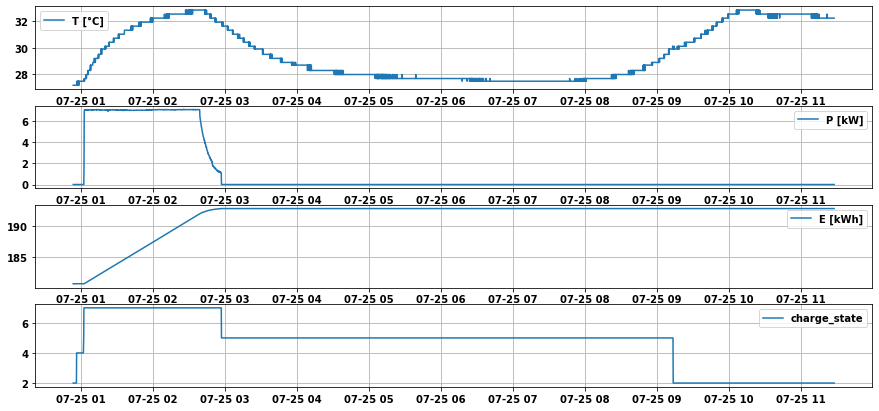

In [17]:
plt.figure(figsize=(15,7))
sigs = ["T [°C]", "P [kW]", "E [kWh]", "charge_state"]
for i, sig in enumerate(sigs):
    plt.subplot(len(sigs), 1, i+1)
    plt.plot(df["datetime"], df[sig], label=sig)
    plt.grid(), plt.legend();

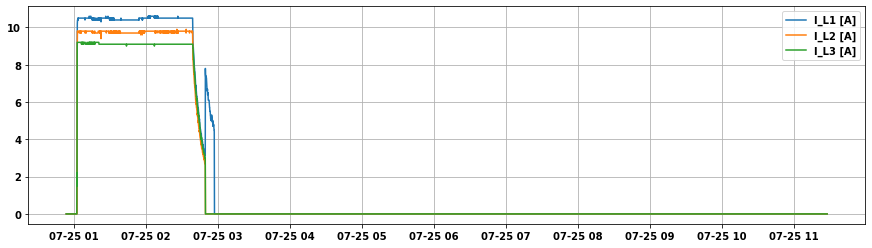

In [18]:
plt.figure(figsize=(15,4))
for col in df.columns:
    if col.startswith("I_L"):
        plt.plot(df["datetime"], df[col], label=col)
plt.grid(), plt.legend();

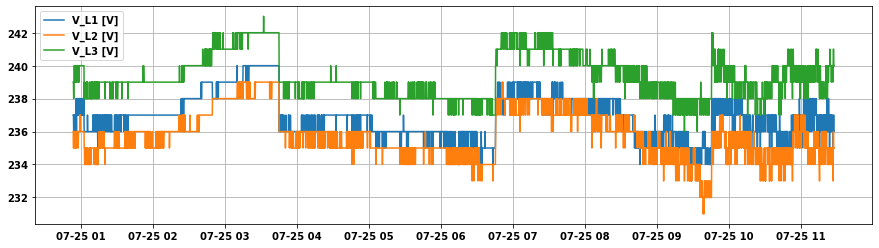

In [19]:
plt.figure(figsize=(15,4))
for col in df.columns:
    if col.startswith("V_L"):
        plt.plot(df["datetime"], df[col], label=col)
plt.grid(), plt.legend();